In [1]:
%reload_ext autoreload
%autoreload 2

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from attrition_prediction.data_processing.processing_io import ReadAttritionDataFromCSV
from attrition_prediction.prediction.estimators import RandomEstimator
from attrition_prediction.prediction.evaluate_model import ModelEvaluator, KFoldColumns
from attrition_prediction.visualization.results_visualization import ResultsPlotting

%matplotlib inline
plt.style.use('ggplot')

In [3]:
def display_n_rows_from_df(data_pd_df, num_rows):
    """Helper function to display all columns and specified number of rows of a pandas DF."""
    with pd.option_context('display.min_rows', num_rows, 'display.max_rows', num_rows, 'display.max_columns', None):
        display(data_pd_df.head(num_rows))
    print(f'Displayed rows: {num_rows}/{len(data_pd_df)}. Columns: {len(data_pd_df.columns)}')

# Attrition Prediction

1. Process the data as in the presentation.
2. One hot encode the data to input to the model.

In [4]:
data_str_path = '/Users/aponcedeleonch/Documents/WorkApplications/Crayon/employee-attrition.csv'
data_pd_df = ReadAttritionDataFromCSV(data_str_path).process_for_prediction()
display_n_rows_from_df(data_pd_df, 3)

Going to remove column: Over18. Contains single value
Going to remove column: StandardHours. Contains single value
Transforming Age to categorized column.
Transforming DailyRate to categorized column.
Transforming DistanceFromHome to categorized column.
Transforming HourlyRate to categorized column.
Transforming MonthlyIncome to categorized column.
Transforming MonthlyRate to categorized column.
Transforming NumCompaniesWorked to categorized column.
Transforming PercentSalaryHike to categorized column.
Transforming RelationshipSatisfaction to categorized column.
Transforming TotalWorkingYears to categorized column.
Transforming YearsAtCompany to categorized column.
Transforming YearsInCurrentRole to categorized column.
Transforming YearsSinceLastPromotion to categorized column.
Transforming YearsWithCurrManager to categorized column.


,"PercentSalaryHike_[0.1, 0.25)Q\n[11.0, 12.0)","PercentSalaryHike_[0.25, 0.5)Q\n[12.0, 14.0)","PercentSalaryHike_[0.5, 0.75)Q\n[14.0, 18.0)","PercentSalaryHike_[0.75, 0.9)Q\n[18.0, 21.0)","PercentSalaryHike_[0.9,1]Q\n[21.0, 25.0]","RelationshipSatisfaction_[0.1, 0.25)Q\n[1.0, 2.0)","RelationshipSatisfaction_[0.25, 0.5)Q\n[2.0, 3.0)","RelationshipSatisfaction_[0.5, 0.75)Q\n[3.0, 4.0)","RelationshipSatisfaction_[0.9,1]Q\n[4.0, 4.0]",JobSatisfaction_1,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,"DailyRate_[0,0.1)Q\n(102.0, 242.8)","DailyRate_[0.1, 0.25)Q\n[242.8, 465.0)","DailyRate_[0.25, 0.5)Q\n[465.0, 802.0)","DailyRate_[0.5, 0.75)Q\n[802.0, 1157.0)","DailyRate_[0.75, 0.9)Q\n[1157.0, 1356.0)","DailyRate_[0.9,1]Q\n[1356.0, 1499.0]","Age_[0,0.1)Q\n(18.0, 26.0)","Age_[0.1, 0.25)Q\n[26.0, 30.0)","Age_[0.25, 0.5)Q\n[30.0, 36.0)","Age_[0.5, 0.75)Q\n[36.0, 43.0)","Age_[0.75, 0.9)Q\n[43.0, 50.0)","Age_[0.9,1]Q\n[50.0, 60.0]",JobInvolvement_1,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,WorkLifeBalance_1,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4,"YearsWithCurrManager_[0.1, 0.25)Q\n[0.0, 2.0)","YearsWithCurrManager_[0.25, 0.5)Q\n[2.0, 3.0)","YearsWithCurrManager_[0.5, 0.75)Q\n[3.0, 7.0)","YearsWithCurrManager_[0.75, 0.9)Q\n[7.0, 9.0)","YearsWithCurrManager_[0.9,1]Q\n[9.0, 17.0]","YearsSinceLastPromotion_[0.25, 0.5)Q\n[0.0, 1.0)","YearsSinceLastPromotion_[0.5, 0.75)Q\n[1.0, 3.0)","YearsSinceLastPromotion_[0.75, 0.9)Q\n[3.0, 7.0)","YearsSinceLastPromotion_[0.9,1]Q\n[7.0, 15.0]",StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,"YearsInCurrentRole_[0.1, 0.25)Q\n[0.0, 2.0)","YearsInCurrentRole_[0.25, 0.5)Q\n[2.0, 3.0)","YearsInCurrentRole_[0.5, 0.75)Q\n[3.0, 7.0)","YearsInCurrentRole_[0.75, 0.9)Q\n[7.0, 9.0)","YearsInCurrentRole_[0.9,1]Q\n[9.0, 18.0]",EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,"MonthlyIncome_[0,0.1)Q\n(1009.0, 2317.6)","MonthlyIncome_[0.1, 0.25)Q\n[2317.6, 2911.0)","MonthlyIncome_[0.25, 0.5)Q\n[2911.0, 4919.0)","MonthlyIncome_[0.5, 0.75)Q\n[4919.0, 8379.0)","MonthlyIncome_[0.75, 0.9)Q\n[8379.0, 13775.6)","MonthlyIncome_[0.9,1]Q\n[13775.6, 19999.0]","YearsAtCompany_[0,0.1)Q\n(0.0, 1.0)","YearsAtCompany_[0.1, 0.25)Q\n[1.0, 3.0)","YearsAtCompany_[0.25, 0.5)Q\n[3.0, 5.0)","YearsAtCompany_[0.5, 0.75)Q\n[5.0, 9.0)","YearsAtCompany_[0.75, 0.9)Q\n[9.0, 15.0)","YearsAtCompany_[0.9,1]Q\n[15.0, 40.0]",PerformanceRating_3,PerformanceRating_4,"MonthlyRate_[0,0.1)Q\n(2094.0, 4603.0)","MonthlyRate_[0.1, 0.25)Q\n[4603.0, 8047.0)","MonthlyRate_[0.25, 0.5)Q\n[8047.0, 14235.5)","MonthlyRate_[0.5, 0.75)Q\n[14235.5, 20461.5)","MonthlyRate_[0.75, 0.9)Q\n[20461.5, 24001.7)","MonthlyRate_[0.9,1]Q\n[24001.7, 26999.0]",TrainingTimesLastYear_0,TrainingTimesLastYear_1,TrainingTimesLastYear_2,TrainingTimesLastYear_3,TrainingTimesLastYear_4,TrainingTimesLastYear_5,TrainingTimesLastYear_6,"TotalWorkingYears_[0,0.1)Q\n(0.0, 3.0)","TotalWorkingYears_[0.1, 0.25)Q\n[3.0, 6.0)","TotalWorkingYears_[0.25, 0.5)Q\n[6.0, 10.0)","TotalWorkingYears_[0.5, 0.75)Q\n[10.0, 15.0)","TotalWorkingYears_[0.75, 0.9)Q\n[15.0, 23.0)","TotalWorkingYears_[0.9,1]Q\n[23.0, 40.0]","NumCompaniesWorked_[0.1, 0.25)Q\n[0.0, 1.0)","NumCompaniesWorked_[0.25, 0.5)Q\n[1.0, 2.0)","NumCompaniesWorked_[0.5, 0.75)Q\n[2.0, 4.0)","NumCompaniesWorked_[0.75, 0.9)Q\n[4.0, 7.0)","NumCompaniesWorked_[0.9,1]Q\n[7.0, 9.0]",Gender_Female,Gender_Male,"HourlyRate_[0,0.1)Q\n(30.0, 38.0)","HourlyRate_[0.1, 0.25)Q\n[38.0, 48.0)","HourlyRate_[0.25, 0.5)Q\n[48.0, 66.0)","HourlyRate_[0.5, 0.75)Q\n[66.0, 83.8)","HourlyRate_[0.75, 0.9)Q\n[83.8, 94.0)","HourlyRate_[0.9,1]Q\n[94.0, 100.0]",OverTime_No,OverTime_Yes,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,Department_Human Resources,D

Displayed rows: 3/1470. Columns: 143


## Hand-picked relevant attributes for prediction

Based on the plots the following columns of the dataset were picked as a first approach to fit an estimator.

In [5]:
SELECTED_PREDICTION_COLS = [
                            'Age',
                            'BusinessTravel',
                            # 'DailyRate',
                            # 'Department',
                            'DistanceFromHome',
                            # 'Education',
                            'EducationField',
                            'EnvironmentSatisfaction',
                            # 'Gender',
                            # 'HourlyRate',
                            'JobInvolvement',
                            'JobLevel',
                            'JobRole',
                            'JobSatisfaction',
                            'MaritalStatus',
                            'MonthlyIncome',
                            # 'MonthlyRate',
                            'NumCompaniesWorked',
                            'OverTime',
                            # 'PercentSalaryHike',
                            # 'PerformanceRating',
                            'RelationshipSatisfaction',
                            'StockOptionLevel',
                            'TotalWorkingYears',
                            'TrainingTimesLastYear',
                            'WorkLifeBalance',
                            'YearsAtCompany',
                            'YearsInCurrentRole',
                            # 'YearsSinceLastPromotion',
                            'YearsWithCurrManager'
                        ]
model_evaluator = ModelEvaluator(
                                processed_data_df=data_pd_df,
                                test_size=0.3,
                                number_k_splits=5,
                                predictions_features=SELECTED_PREDICTION_COLS,
                                scoring_metric='recall'
                            )

## Explore different estimators.

Explore different common estimators. The performance of each estimator is evaluated with recall.

In [73]:
random_estimator = RandomEstimator()
naive_bayes = GaussianNB()
logistic = LogisticRegression(max_iter=1000)
svc = SVC(class_weight='balanced')
bernoulli_bayes = BernoulliNB()
random_forest = RandomForestClassifier(n_estimators=50, max_depth=8, max_features=100)
estimators = [random_estimator, naive_bayes, logistic, svc, bernoulli_bayes, random_forest]
estimator_names = ['Random', 'Gaussian NB', 'Logistic', 'SVC', 'BernoulliNB', 'RandomForest']
train_scores_models, test_scores_models = [], []
for estimator in estimators:
    avg_train_score, avg_test_score, _ = model_evaluator.evaluate(estimator)
    train_scores_models.append(avg_train_score)
    test_scores_models.append(avg_test_score)

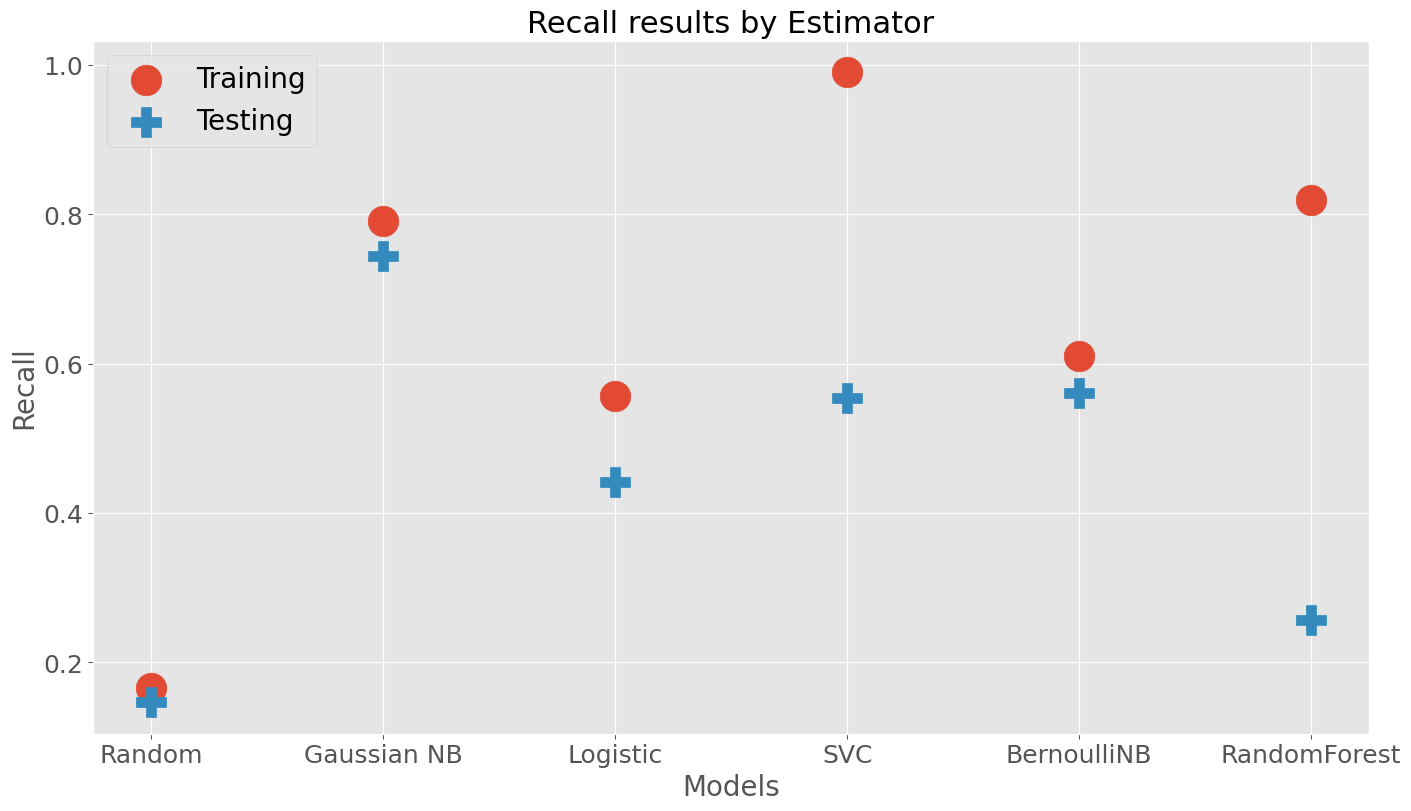

In [74]:
results_plotting = ResultsPlotting(base_fontsize=18)
results_plotting.plot_scores([train_scores_models, test_scores_models], ['Training', 'Testing'], estimator_names)
plt.show()

## Do K-Fold Cross Validation to explore the features.

The best performing model is Naive Bayes. Use this model to explore how different columns affect the prediction.

In [51]:
kfold_columns = KFoldColumns(
                                processed_data_df=data_pd_df,
                                test_size=0.2,
                                validation_size=0.2,
                                number_splits=10,
                                columns_to_test=SELECTED_PREDICTION_COLS,
                                scoring_metric='recall'
                            )
naive_bayes = GaussianNB()
kfold_columns.get_all_folds(naive_bayes)
top_n_folds = kfold_columns.get_top_n_folds(10)

Going to try 1562 combinations.
Obtained 101 combinations.
Obtained 201 combinations.
Obtained 301 combinations.
Obtained 401 combinations.
Obtained 501 combinations.
Obtained 601 combinations.
Obtained 701 combinations.
Obtained 801 combinations.
Obtained 901 combinations.
Obtained 1001 combinations.
Obtained 1101 combinations.
Obtained 1201 combinations.
Obtained 1301 combinations.
Obtained 1401 combinations.
Obtained 1501 combinations.


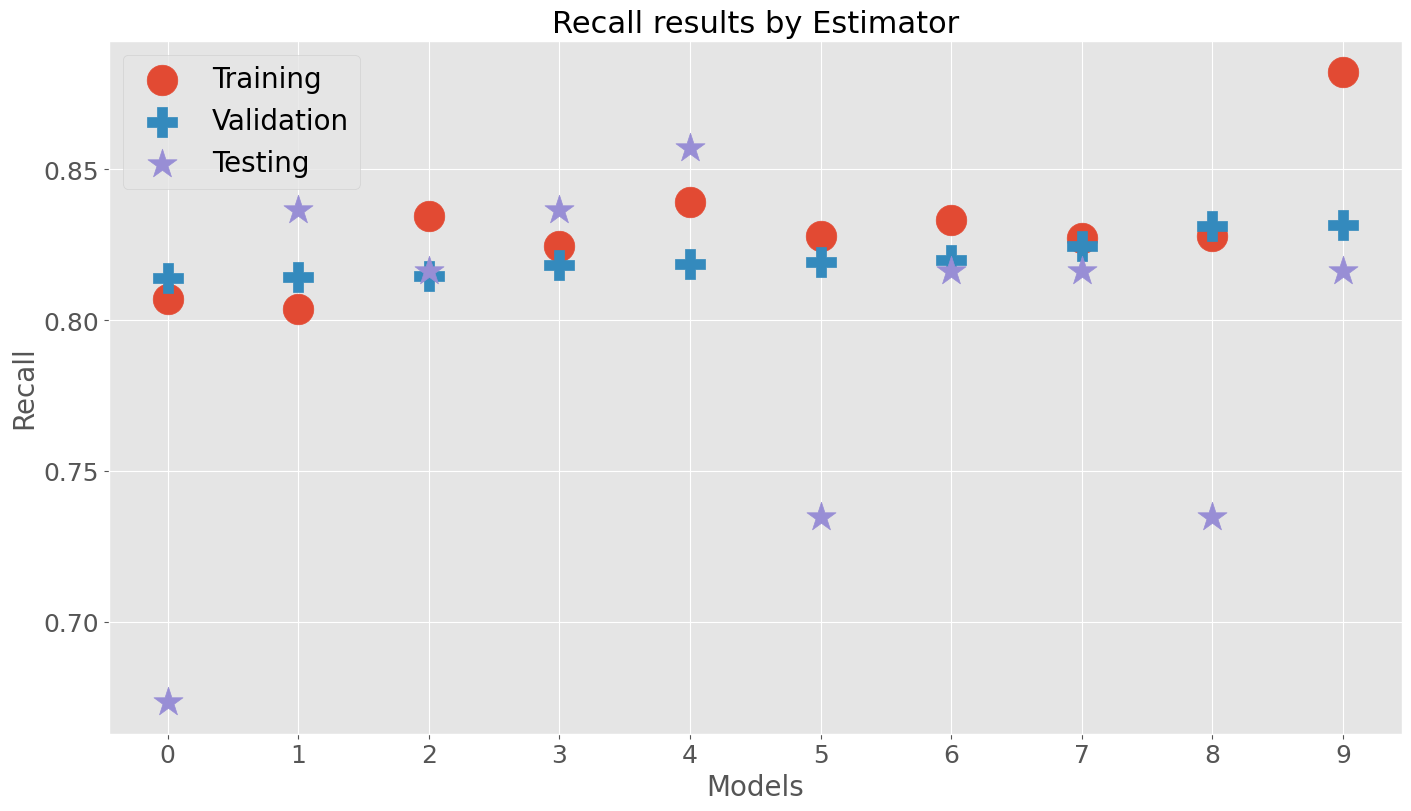

In [69]:
columns_for_models = [sorted(columns) for (_, _, _), columns in top_n_folds]
test_scores = [kfold_columns.get_score_on_test_set(estimator, columns) for (_, _, estimator), columns in top_n_folds]
train_scores = [train_score for (train_score, _, _), _ in top_n_folds]
validation_scores = [validation_score for (_, validation_score, _), _ in top_n_folds]

results_plotting.plot_scores(
                                scores=[train_scores, validation_scores, test_scores],
                                labels=['Training', 'Validation', 'Testing'],
                                models=list(range(len(columns_for_models)))
                            )
plt.show()

In [59]:
first_model_columns = set(columns_for_models[0])
for i_col, columns in enumerate(columns_for_models):
    if i_col == 0:
        print(f'Model: {i_col}.\n{first_model_columns}')    
    else:
        model_columns = set(columns)
        diff_cols_wrt_first = model_columns - first_model_columns
        diff_cols_wrt_first = model_columns - first_model_columns
        print(
                f'Model: {i_col}.\n'
                f'Unique in curr: {model_columns - first_model_columns}\n'
                f'Unique in first: {first_model_columns - model_columns}'
            )

Model: 0.
{'RelationshipSatisfaction', 'JobSatisfaction', 'Age', 'JobInvolvement', 'BusinessTravel', 'NumCompaniesWorked', 'JobLevel', 'MonthlyIncome', 'OverTime', 'WorkLifeBalance', 'YearsWithCurrManager', 'StockOptionLevel', 'EnvironmentSatisfaction', 'JobRole', 'EducationField', 'MaritalStatus', 'DistanceFromHome', 'YearsAtCompany'}
Model: 1.
Unique in curr: {'TotalWorkingYears', 'YearsInCurrentRole', 'TrainingTimesLastYear'}
Unique in first: {'Age', 'JobSatisfaction', 'EnvironmentSatisfaction'}
Model: 2.
Unique in curr: {'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsInCurrentRole'}
Unique in first: {'MaritalStatus', 'EnvironmentSatisfaction'}
Model: 3.
Unique in curr: {'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsInCurrentRole'}
Unique in first: {'Age', 'MonthlyIncome'}
Model: 4.
Unique in curr: {'YearsInCurrentRole', 'TrainingTimesLastYear'}
Unique in first: {'Age', 'YearsAtCompany'}
Model: 5.
Unique in curr: {'YearsInCurrentRole', 'TrainingTimesLastYear'}
Unique in f